# Lab 2
## Louis Gauthy (i6188059) & Louis Meeckers (i6258699)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import ssl
from PIL import Image
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model

ssl._create_default_https_context = ssl._create_unverified_context

# Load the data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Concatenate
x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# 80% train, 10% validation, 10% test
x_train, x_test, _, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, _, _ = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Print shape
print (x_train.shape) # 80% => 48 000 instances
print (x_val.shape) # 10% => 6 000 instances
print (x_test.shape) # 10% => 6 000 instances

(48000, 32, 32, 3)
(6000, 32, 32, 3)
(6000, 32, 32, 3)


In [3]:
print("max pixel values = ",np.max(x_train))
print("max pixel values = ",np.min(x_train))

max pixel values =  1.0
max pixel values =  0.0


# Reconstruction

## Create autoencoder

In [4]:
class Autoencoder(Model):

  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(8, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)),
      layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(12, kernel_size=3, strides=1, padding='same', activation='relu'),
      layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=3, strides=1, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(2, 2)),
      layers.Conv2D(12, kernel_size=3, strides=1, padding='same', activation='relu'),
      layers.UpSampling2D(size=(2, 2)),
      layers.Conv2D(output_dim, kernel_size=3, strides=1, padding='same', activation='relu'),
      # layers.Reshape((32, 32, 3))
      # layers.Dense(3072, activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [5]:
class CNNAutoencoder(Model):
    
  def __init__(self, cnn_dim = 4, latent_dim = 16, input_dim = 3, output_dim = 3):
    super(CNNAutoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder_channel_sizes = np.linspace(input_dim, latent_dim, num=cnn_dim)
    self.decoder_channel_sizes = np.linspace(latent_dim, output_dim, num=cnn_dim)

    encoder_seq = []; decoder_seq = []


    for i in self.encoder_channel_sizes:
      if i == input_dim: encoder_seq.append(layers.Conv2D(i, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)))
      elif i== latent_dim: encoder_seq.append(layers.Conv2D(i, kernel_size=3, strides=1, padding='same', activation='relu')); break
      encoder_seq.append(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

    for i in self.decoder_channel_sizes[1:]:
      decoder_seq.append(layers.UpSampling2D(size=(2, 2)))
      decoder_seq.append(layers.Conv2D(i, kernel_size=3, strides=1, padding='same', activation='relu'))

    self.encoder = tf.keras.Sequential(encoder_seq)
    self.decoder = tf.keras.Sequential(decoder_seq)

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


## Display structure NN

In [6]:

autoencoder = Autoencoder()
# Define optimizer and the error function
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")

In [9]:
print(autoencoder.summary())

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 8, 8, 16)          2844      
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         2067      
Total params: 4,911
Trainable params: 4,911
Non-trainable params: 0
_________________________________________________________________
None


## Fit the data (epochs=10)

In [8]:

inital_history = autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10
1500/1500 [==============================] - 31s 20ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 2/10
1500/1500 [==============================] - 31s 20ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 3/10
1500/1500 [==============================] - 32s 21ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 4/10
1500/1500 [==============================] - 33s 22ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 5/10
1500/1500 [==============================] - 32s 21ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 6/10
1500/1500 [==============================] - 32s 21ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoc

In [9]:
def plot_training_curves(acc, val_acc, loss = None, val_loss = None, ft = False):
    
  plt.figure(figsize=(5, 5))
#   plt.subplot(2, 1, 1)
  plt.title("Train and validation MSE over the epochs")
  plt.plot(acc, label='Training MSE')
  plt.plot(val_acc, label='Validation MSE')
  plt.legend(loc='lower right')
  plt.ylabel('Error')
  plt.xlabel("epochs")
  plt.title('Training and Validation Error')

#   plt.subplot(2, 1, 2)
#   plt.plot(loss, label='Training Loss')
#   plt.plot(val_loss, label='Validation Loss')
#   plt.legend(loc='upper right')
#   plt.ylabel('Cross Entropy')
#   plt.title('Training and Validation Loss')
#   plt.xlabel('epoch')
  plt.show()

## The evolution of the Mean Squared Error with epochs

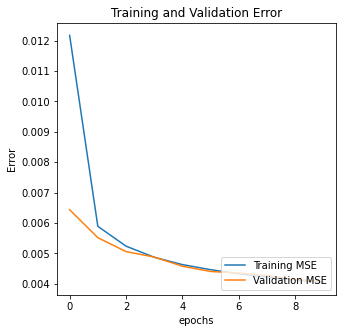

In [9]:
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

It is observed here that the error is dropping in the first epochs then gradualy stabilises towards $\approx$ 0.045

## Model Evaluation

In [10]:
metrics = autoencoder.evaluate(x_test,x_test)
mae = metrics[1]
print('Test Error :', mse)

188/188 [==============================] - 2s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Test Error : [0.012170931324362755, 0.0058909086510539055, 0.00523773580789566, 0.004872499033808708, 0.004631478805094957, 0.004464106168597937, 0.00433002132922411, 0.0042189499363303185, 0.004124506842344999, 0.004044022876769304]


We get a similar error the last epoch's validation error

## Display some results

In [11]:
def plot_test(autoencoder,x_test,gray = False):
 encoded_imgs = autoencoder.encoder(x_test).numpy()
 decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

 if gray:
  x_test = x_test.numpy()
  test_re = rgb_convertion(decoded_imgs,x_test)

 iStart = 10 # only change this value to display different value (must be >= 0)
 n = 10
 plt.figure(figsize=(20, 4))
 for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  if gray: plt.imshow((x_test[iStart + i].T[0][:][:]).T)
  else: plt.imshow(x_test[iStart + i])

  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  if gray:   plt.imshow(test_re[iStart + i])
  else :  plt.imshow(decoded_imgs[iStart + i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
 plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


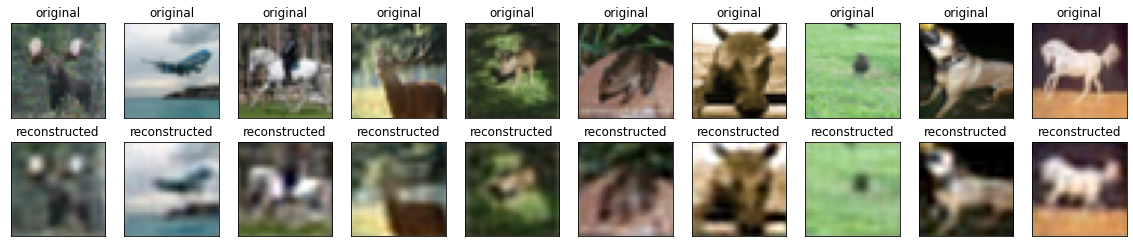

In [238]:
plot_test(autoencoder,x_test)

# Latent space

In [13]:
s = 1 #strides
c = 16 #channels
w = 32*3 #input volume
k = 3 #kernel size
p = (k-1)/2 #padding (forumla is for padding = same!)

def lspace_size(c,k,s,w,p = (k-1)/2):
   return c*np.power(1+ w-k+2*p/s,2)

print("latent space size = ",lspace_size(c,k,s,w))

latent space size =  147456.0


# Hyper parameter tuning
> e.g. fewer intermediate layers, different number of channels, filter sizes or stride and
padding configurations) 
-> What is the impact of those in the reconstruction error after training? Is there an obvious correlation between the size of the latent space representation and the error?

In [15]:
def build_ae(latent_dim = 16, verbose = 0):
    autoencoder = Autoencoder(latent_dim)
   # Define optimizer and the error function
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
    history = autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                verbose=verbose,
                validation_data=(x_val, x_val))
    return history.history['val_mean_squared_error']

# error = build_ae(latent_dim = 32)
# print(error)



## Mean squared error according to the number of dimensions in the last convolutional layer of the encoder 

In [18]:
# Is there an obvious correlation between the size of the latent space representation and the error?
# dims = np.power(2,np.arange(1,12,1))
dims = [2, 4, 8, 16, 32, 64]
print(dims)

errors = []
for dim in dims:
    error = build_ae(latent_dim = dim)
    errors.append(error[len(error)-1])
    print(dim, error[len(error)-1])

[2, 4, 8, 16, 32, 64]
2 0.01259929034858942
4 0.00482218200340867
8 0.004560419358313084
16 0.004137229174375534
32 0.0037965828087180853
64 0.0035522794350981712


In [19]:
# Is there an obvious correlation between the size of the latent space representation and the error?
# dims = np.power(2,np.arange(1,12,1))
dims = [128, 256, 512, 640]
print(dims)

errors = []
for dim in dims:
    error = build_ae(latent_dim = dim)
    errors.append(error[len(error)-1])
    print(dim, error[len(error)-1])

[128, 256, 512, 640]
128 0.003196542151272297
256 0.003124689683318138
512 0.0033389939926564693
640 0.0032702074386179447


In [20]:
# Is there an obvious correlation between the size of the latent space representation and the error?
# dims = np.power(2,np.arange(1,12,1))
dims = [768, 896, 1024, 1280]
print(dims)

errors = []
for dim in dims:
    error = build_ae(latent_dim = dim)
    errors.append(error[len(error)-1])
    print(dim, error[len(error)-1])

[768, 896, 1024, 1280]
768 0.003082230454310775
896 0.002788195386528969
1024 0.003305373713374138
1280 0.0031323025468736887


In [21]:
# Is there an obvious correlation between the size of the latent space representation and the error?
# dims = np.power(2,np.arange(1,12,1))
dims = [1536, 1792, 2048]
print(dims)

errors = []
for dim in dims:
    error = build_ae(latent_dim = dim)
    errors.append(error[len(error)-1])
    print(dim, error[len(error)-1])

[1536, 1792, 2048]
1536 0.0028343768790364265
1792 0.0029489551670849323


> Previous comment when build_ae was using mean absolute error:

The experiment above is building many autoencoders with different dimensions for the last convolutional layer of the encoder. Due to the fact that this experiment took 478 minutes (almost 8 hours) and realised in multiple times, we copied the results in the array bellow (called "errors") to not lose the results.

ValueError: x and y must have same first dimension, but have shapes (6,) and (11,)

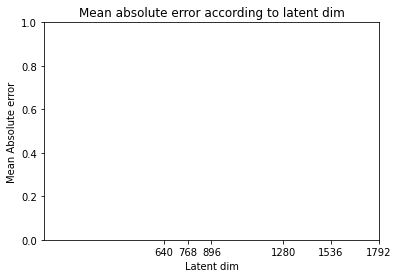

In [17]:
# Result when build_ae was using mean absolute error: 
errors = [0.01259929034858942, 0.00482218200340867, 0.004560419358313084,  0.004137229174375534,  0.0037965828087180853,  0.0035522794350981712, 128 0.003196542151272297, 0.003124689683318138, 0.0033389939926564693, 0.0032702074386179447, 768 0.003082230454310775, 0.002788195386528969, 0.003305373713374138, 0.0031323025468736887, 0.0028343768790364265, 0.0029489551670849323]
dims = [2, 4, 8, 16, 32, 64, 128, 256, 512, 640, 768, 896, 1024, 1280, 1536, 1792]

plt.title("Mean squared error according to latent dim")
plt.xlabel("Latent dim")
plt.ylabel("Mean Absolute error")

plt.xticks(dims)

plt.plot(dims, errors)

plt.show()

# Colorization

## RGB convertion to YCbCr

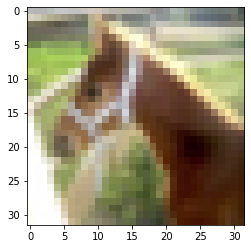

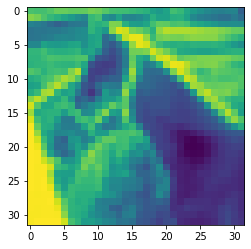

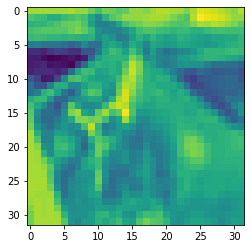

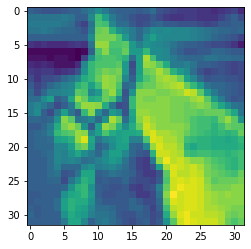

In [200]:
im_arr = x_test[1]
image = array_to_img(im_arr)
plt.imshow(image)
ycbcr = image.convert('YCbCr')
y, cb, cr = ycbcr.split()


y_arr = np.array(y)
cb_arr = np.array(cb)
cr_arr = np.array(cr)
c_arr = np.dstack((cb_arr,cr_arr))
plt.figure()
plt.imshow(y)
plt.figure()
plt.imshow(cb)
plt.figure()
plt.imshow(cr)


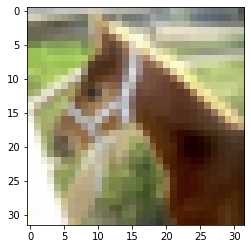

In [217]:
y_re = Image.fromarray(y_arr, mode ="L")
cb_arr= (c_arr.T[0][:][:]).T
cr_arr= (c_arr.T[1][:][:]).T
cb_re = Image.fromarray(cb_arr, mode ="L")
cr_re = Image.fromarray(cr_arr, mode ="L")

x= Image.merge('YCbCr', (y_re, cb_re, cr_re)).convert('RGB')

plt.imshow(x)

In [8]:
def lum_chrom_convertion(data):
 chromas = []
 luminas = []
 for im_arr in data:
  ycbcr = array_to_img(im_arr).convert('YCbCr')
  y, cb, cr = ycbcr.split()
  y_arr = np.array(y)
  luminas.append(y_arr)
  chromas.append(np.dstack((np.array(cb),np.array(cr))))
 return [np.array(chromas),np.array(luminas)]

def rgb_convertion(chrom,lum):
 rgbs = []
 for i in range(len(lum)):
  y_re = Image.fromarray((lum[i].T[0][:][:]).T, mode ="L")
  c_arr = chrom[i]
  cb_re = Image.fromarray((c_arr.T[0][:][:]).T, mode ="L")
  cr_re = Image.fromarray((c_arr.T[1][:][:]).T, mode ="L")
  x= Image.merge('YCbCr', (y_re, cb_re, cr_re)).convert("RGB")
  rgbs.append(np.array(x))
 return rgbs

def gray_convertion(data):
    grays=[]
    for im_arr in data:
       gray = array_to_img(im_arr).convert('L')
       gray_arr = np.array(gray)
       grays.append((gray_arr))
    return tf.expand_dims(np.array(grays), axis=-1)


In [14]:
[chrom_test,lum_test] = lum_chrom_convertion(x_test)
[chrom_train,lum_train] = lum_chrom_convertion(x_train)
[chrom_val,lum_val] = lum_chrom_convertion(x_val)

gray_test = gray_convertion(x_test)
gray_train = gray_convertion(x_train)
gray_val = gray_convertion(x_val)

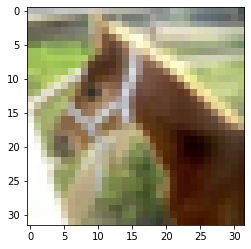

In [44]:
test_re = rgb_convertion(chrom_test,gray_test.numpy())
plt.imshow(test_re[1])

## Training

In [15]:
gray_ae = CNNAutoencoder(cnn_dim = 4,latent_dim=256,input_dim=1,output_dim=2)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

Epoch 1/10
1500/1500 [==============================] - 386s 256ms/step - loss: 691.6519 - mean_squared_error: 691.6519 - val_loss: 410.0434 - val_mean_squared_error: 410.0434
Epoch 2/10
1500/1500 [==============================] - 382s 254ms/step - loss: 394.3675 - mean_squared_error: 394.3675 - val_loss: 315.2333 - val_mean_squared_error: 315.2333
Epoch 3/10
1500/1500 [==============================] - 344s 230ms/step - loss: 289.5666 - mean_squared_error: 289.5666 - val_loss: 258.6096 - val_mean_squared_error: 258.6096
Epoch 4/10
1500/1500 [==============================] - 366s 244ms/step - loss: 263.4694 - mean_squared_error: 263.4694 - val_loss: 249.4511 - val_mean_squared_error: 249.4511
Epoch 5/10
1500/1500 [==============================] - 355s 236ms/step - loss: 259.1273 - mean_squared_error: 259.1273 - val_loss: 269.1133 - val_mean_squared_error: 269.1133
Epoch 6/10
1500/1500 [==============================] - 415s 277ms/step - loss: 259.0301 - mean_squared_error: 259.0301 

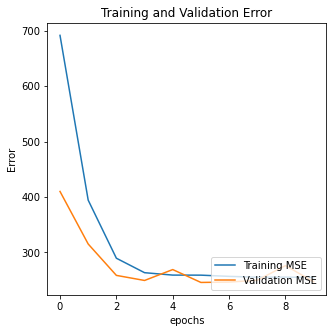

In [16]:
mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

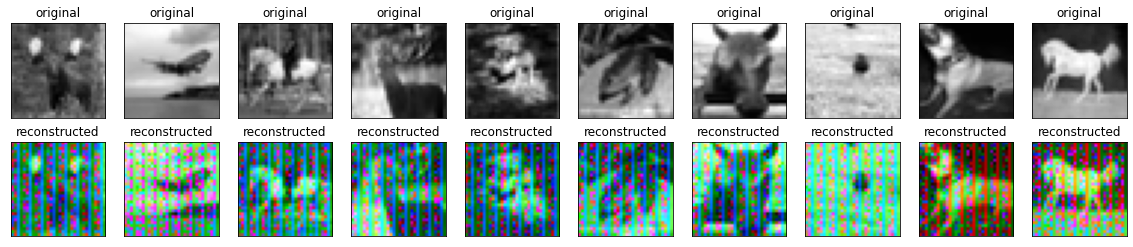

In [17]:
plot_test(gray_ae,gray_test,gray = True)